# The `StreamPowerSmoothThresholdEroder` component

Landlab's `StreamPowerSmoothThresholdEroder` (here SPSTE for short) is a fluvial landscape evolution component that uses a thresholded form of the stream power erosion law. The novel aspect is that the threshold takes a smoothed form rather than an abrupt mathematical discontinuity: as long as slope and drainage area are greater than zero, there is always *some* erosion rate even if the erosive potential function is below the nominal threshold value. This approach is motivated by the finding that mathematically discontinuous functions in numerical models can lead to "numerical daemons": non-smooth functional behavior that can greatly complicate optimization (Clark & Kavetski, 2010; Kavetski & Clark, 2010, 2011). The SPSTE is one of the fluvial erosion components used in the *terrainBento* collection of landscape evolution models (Barnhart et al., 2019).

This tutorial provides a brief overview of how to use the SPSTE component.

*(G.E. Tucker, 2021)*

## Theory

The SPSTE formulation is as follows. Consider a location on a stream channel that has local downstream slope gradient $S$ and drainage area $A$. We define an erosion potential function $\omega$ as

$$\omega = KA^mS^n$$

where $K$ is an erodibility coefficient with dimensions of $[L^{(1-2m)}/T]$. The erosion potential function has dimensions of erosion (lowering) rate, [L/T], and it represents the rate of erosion that would occur if there were no threshold term. The expression takes the form of the familiar area-slope erosion law, also known as the "stream power law" because the exponents can be configured to represent an erosion law that depends on stream power per unit bed area (Whipple & Tucker, 1999). A common choice of exponents is $m=1/2$, $n=1$, but other combinations are possible depending on one's assumptions about process, hydrology, channel geometry, and other factors (e.g., Howard et al., 1994; Whipple et al., 2000).

We also define a threshold erosion potential function, $\omega_c$, below which erosion rate declines precipitously. Given these definitions, a mathematically discontinuous threshold erosion function would look like this:

$$E = \max (\omega - \omega_c, 0)$$

This kind of formulation is mathematically simple, and given data on $E$ and $\omega$, one could easily find $K$ and $\omega_c$ empirically by fitting a line. Yet even in the case of sediment transport, where the initial motion of grains is usually represented by a threshold shear stress (often referred to as the *critical shear stress* for initiation of sediment motion), we know that *some* transport still occurs below the nominal threshold (e.g, Wilcock & McArdell, 1997). Although it is undeniably true that the rate of sediment transport declines rapidly when the average shear stress drops below a critical value, the strictly linear-with-threshold formulation is really more of convenient mathematical fiction than an accurate reflection of geophysical reality. In bed-load sediment transport, reality seems to be smoother than this mathematical fiction, if one transport rates averaged over a suitably long time period. The same is likely true for the hydraulic detachment and removal of cohesive/rocky material as well. Furthermore, as alluded to above, a strict threshold expression for transport or erosion can create numerical daemons that complicate model analysis.

To avoid the mathematical discontinuity at $\omega=\omega_c$, SPSTE uses a smoothed version of the above function:

$$E = \omega - \omega_c \left( 1 - e^{-\omega / \omega_c} \right)$$

The code below generates a plot that compares the strict threshold and smooth threshold erosion laws.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from landlab import RasterModelGrid, imshow_grid
from landlab.components import FlowAccumulator, StreamPowerSmoothThresholdEroder

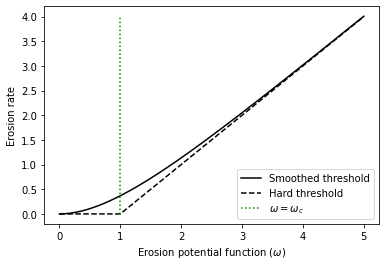

In [2]:
omega = np.arange(0, 5.01, 0.01)
omegac = 1.0
Eabrupt = np.maximum(omega - omegac, 0.0)
Esmooth = omega - omegac * (1.0 - np.exp(-omega / omegac))

plt.plot(omega, Esmooth, "k", label="Smoothed threshold")
plt.plot(omega, Eabrupt, "k--", label="Hard threshold")
plt.plot([1.0, 1.0], [0.0, 4.0], "g:", label=r"$\omega=\omega_c$")
plt.xlabel(r"Erosion potential function ($\omega$)")
plt.ylabel("Erosion rate")
plt.legend()

Notice that the SPSTE formulation effectively smooths over the sharp discontinuity at $\omega = \omega_c$.

### Equilibrium

Consider a case of steady, uniform fluvial erosion. Let the ratio of the erosion potential function to its threshold value be a constant, as

$$\beta = \omega / \omega_c$$

This allows us to replace instances of $\omega_c$ with $(1/\beta) \omega$,

$$E = KA^m S^n - \frac{1}{\beta} KA^m S^n \left( 1 - e^{-\beta} \right)$$

$$ = K A^m S^n \left( 1 - \frac{1}{\beta}  \left( 1 - e^{-\beta} \right)\right)$$

Let
$$\alpha = \left( 1 - \frac{1}{\beta}  \left( 1 - e^{-\beta} \right)\right)$$

Then we can solve for the steady-state slope as

$$\boxed{S = \left( \frac{E}{\alpha K A^m} \right)^{1/n}}$$

We can relate $\beta$ and $\omega_c$ via

$$\omega_c = E / (1-\beta (1 - e^{-\beta} ))$$

## Usage

Here we get a summary of the component's usage and input parameters by printing out the component's header docstring:

In [3]:
print(StreamPowerSmoothThresholdEroder.__doc__)

Stream erosion component with smooth threshold function.

    Parameters
    ----------
    grid : ModelGrid
        A grid.
    K_sp : float, array, or field name
        K in the stream power equation (units vary with other parameters).
    m_sp : float, optional
        m in the stream power equation (power on drainage area).
    n_sp : float, optional, ~ 0.5<n_sp<4.
        n in the stream power equation (power on slope). NOTE: NOT PRESENTLY
        HONORED BY StreamPowerSmoothThresholdEroder (TODO)
    threshold_sp : float (TODO: array, or field name)
        The threshold stream power.
    discharge_field : float, field name, or array, optional
        Discharge [L^2/T]. The default is to use the grid field
        'drainage_area'. To use custom spatially/temporally varying
        rainfall, use 'water__unit_flux_in' to specify water input to the
        FlowAccumulator and use "surface_water__discharge" for this
        keyword argument.
    erode_flooded_nodes : bool (optional)

## Example

Here we'll run a steady-state example with $\beta = 1$. To do this, we'll start with a slightly inclined surface with some superimposed random noise, and subject it to a steady rate of rock uplift relative to baselevel, $U$, until it reaches a steady state.

In [29]:
# Parameters
K = 0.0001  # erodibility coefficient, 1/yr
m = 0.5  # drainage area exponent
beta = 1.0  # ratio of w / wc [-]
beta = 0.5  # ratio of w / wc [-]

uplift_rate = 0.001  # rate of uplift relative to baselevel, m/yr
uplift_rate = 0.0005  # rate of uplift relative to baselevel, m/yr

nrows = 16  # number of grid rows (small for speed)
ncols = 25  # number of grid columns (")
dx = 100.0  # grid spacing, m
dt = 1000.0  # time-step duration, yr
run_duration = 2.5e5  # duration of run, yr
init_slope = 0.001  # initial slope gradient of topography, m/m
noise_amplitude = 0.1  # amplitude of random noise on init. topo.

# Derived parameters
omega_c = uplift_rate / (beta - (1 - np.exp(-beta)))
nsteps = int(run_duration / dt)

In [30]:
# Create grid and elevation field with initial ramp
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(True, True, True, False)
elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = init_slope * grid.y_of_node
np.random.seed(0)
elev[grid.core_nodes] += noise_amplitude * np.random.rand(grid.number_of_core_nodes)

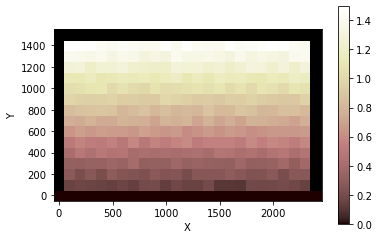

In [31]:
# Display starting topography
imshow_grid(grid, elev)

In [32]:
# Instantiate the two components
# (note that m=0.5, n=1 are the defaults for SPSTE)
fa = FlowAccumulator(grid, flow_director="D8")
spste = StreamPowerSmoothThresholdEroder(grid, K_sp=K, threshold_sp=omega_c)

In [33]:
print(omega_c)

0.00938696899745


In [34]:
# Run the model
for i in range(nsteps):
    # flow accumulation
    fa.run_one_step()

    # uplift / baselevel
    elev[grid.core_nodes] += uplift_rate * dt

    # erosion
    spste.run_one_step(dt)

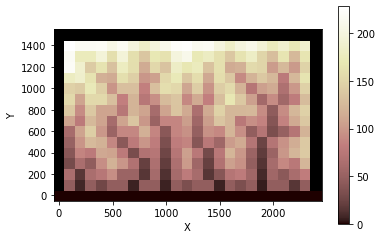

In [35]:
# Display the final topopgraphy
imshow_grid(grid, elev)

In [36]:
# Calculate the analytical solution in slope-area space
alpha = 1.0 - (1.0 / beta) * (1.0 - np.exp(-beta))
area_pred = np.array([1.0e4, 1.0e6])
slope_pred = uplift_rate / (alpha * K * area_pred**m)

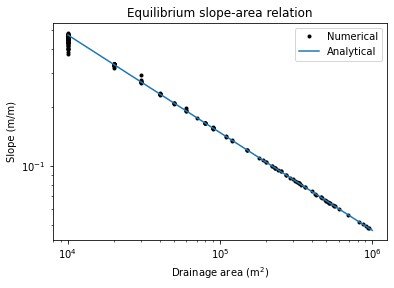

In [37]:
# Plot the slope-area relation and compare with analytical
area = grid.at_node["drainage_area"]
slope = grid.at_node["topographic__steepest_slope"]
cores = grid.core_nodes
plt.loglog(area[cores], slope[cores], "k.")
plt.plot(area_pred, slope_pred)
plt.legend(["Numerical", "Analytical"])
plt.title("Equilibrium slope-area relation")
plt.xlabel(r"Drainage area (m$^2$)")
_ = plt.ylabel("Slope (m/m)")

The above plot shows that the simulation has reached steady state, and that the slope-area relation matches the analytical solution.

We can also inspect the erosion potential function, which should be uniform in space, and (because $\beta = 1$ in this example) equal to the threshold $\omega_c$. We can also compare this with the uplift rate and the erosion-rate function:

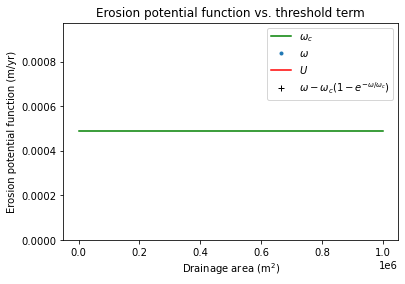

In [28]:
# Plot the erosion potential function
omega = K * area[cores] ** m * slope[cores]
plt.plot([0.0, 1.0e6], [omega_c, omega_c], "g", label=r"$\omega_c$")
plt.plot(area[cores], omega, ".", label=r"$\omega$")
plt.plot([0.0, 1.0e6], [uplift_rate, uplift_rate], "r", label=r"$U$")
erorate = omega - omega_c * (1.0 - np.exp(-omega / omega_c))
plt.plot(
    area[cores], erorate, "k+", label=r"$\omega - \omega_c (1 - e^{-\omega/\omega_c})$"
)
plt.ylim([0.0, 2 * omega_c])
plt.legend()
plt.title("Erosion potential function vs. threshold term")
plt.xlabel(r"Drainage area (m$^2$)")
_ = plt.ylabel("Erosion potential function (m/yr)")

The above plot illustrates how the SPSTE allows erosion to occur even when the erosion potential lies at or below the nominal threshold.

## References

Barnhart, K. R., Glade, R. C., Shobe, C. M., & Tucker, G. E. (2019). Terrainbento 1.0: a Python package for multi-model analysis in long-term drainage basin evolution. Geoscientific Model Development, 12(4), 1267-1297.

Clark, M. P., & Kavetski, D. (2010). Ancient numerical daemons of conceptual hydrological modeling: 1. Fidelity and efficiency of time stepping schemes. Water Resources Research, 46(10).

Howard, A. D., Dietrich, W. E., & Seidl, M. A. (1994). Modeling fluvial erosion on regional to continental scales. Journal of Geophysical Research: Solid Earth, 99(B7), 13971-13986.

Kavetski, D., & Clark, M. P. (2010). Ancient numerical daemons of conceptual hydrological modeling: 2. Impact of time stepping schemes on model analysis and prediction. Water Resources Research, 46(10).

Kavetski, D., & Clark, M. P. (2011). Numerical troubles in conceptual hydrology: Approximations, absurdities and impact on hypothesis testing. Hydrological Processes, 25(4), 661-670.

Whipple, K. X., Hancock, G. S., & Anderson, R. S. (2000). River incision into bedrock: Mechanics and relative efficacy of plucking, abrasion, and cavitation. Geological Society of America Bulletin, 112(3), 490-503.

Whipple, K. X., & Tucker, G. E. (1999). Dynamics of the stream‐power river incision model: Implications for height limits of mountain ranges, landscape response timescales, and research needs. Journal of Geophysical Research: Solid Earth, 104(B8), 17661-17674.

Wilcock, P. R., & McArdell, B. W. (1997). Partial transport of a sand/gravel sediment. Water Resources Research, 33(1), 235-245.